# Steel Plant Complaints - Data Analysis - Part1

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [3]:
# loading dataset
df = pd.read_csv("trainee_complaint.csv") 
df.describe(include=[np.object])

,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION
count,34399,32185,34399,34399,34399,30404,463,15793,34399,13357,20240,507
unique,25045,2255,16,7,45,99,17,246,8,9569,4,243
top,4/2/21 16:03,214Q,A,ELECTRICAL,Tube Light / Bulb Holder,Tube Light,Wire,Bed Room - 1,COMPLETED,not working,9.30-11.00,R.No.5
freq,11,131,5171,14579,4683,3483,107,4072,18728,386,15821,15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34399 entries, 0 to 34398
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   SLNO                34399 non-null  int64 
 1   COMPLAINT_DATE      34399 non-null  object
 2   QTR_NO              32185 non-null  object
 3   SECTOR              34399 non-null  object
 4   CAT_DESCRIPTION     34399 non-null  object
 5   COMPLAINT_TYPE      34399 non-null  object
 6   COMPLAINT_ITEM      30404 non-null  object
 7   COMPLAINT_PROBLEM   463 non-null    object
 8   COMPLAINT_LOCATION  15793 non-null  object
 9   STATUS              34399 non-null  object
 10  REMARKS             13357 non-null  object
 11  RES_PREF_TIME       20240 non-null  object
 12  SUBLOCATION         507 non-null    object
dtypes: int64(1), object(12)
memory usage: 3.4+ MB


Based on above descriptions, 
- There is a total of 34399 rows.
- There are total of 12 columns.
    - Most of the columns are categorical
    - **COMPLAINT_DATE** can be treated as time series data
- Dataset contains complaints from 17/2/2021 to 2/6/2021
- Most complaints are related to **ELECTRICAL** and complaint type is mostly **Tube Light / Bulb Holder**, with complaint item being **Tube Light**.
- Most preferred time of attending to complaints (i.e) **RES_PREF_TIME** is 9:30-11:00

### Data Preprocessing

In the data preprocessing, following issues will be addressed
- Handling missing values
- Information like date, time, and month will be extracted COMPLAINT_DATE time will be considered as time series data
- Removing duplicate rows

#### Missing Values

Handling missing values is an essential part of data pre-processing, otherwise it would lead to runtime errors.

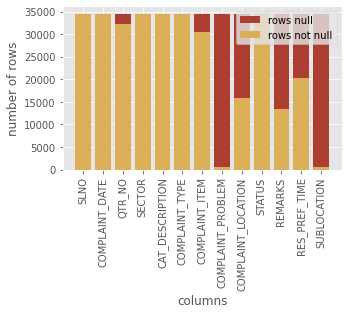

In [5]:
#plotting missing values
total_rows=len(df)
not_null_counts=[]
for col in df.columns:   
    not_null_counts.append(df[col].count())
plt.style.use('ggplot')
plt.figure(figsize=(5,3))
plt.xlabel('columns')
plt.ylabel('number of rows')
plt.xticks(rotation=90)
plt.bar(df.columns, [total_rows for col in df.columns],  color='#ac3e31', label='total=1460')
plt.bar(df.columns, not_null_counts,  color='#dbae58', label='rows not null')
plt.legend(['rows null','rows not null'])

plt.show()
    

- From the above graph, we observe that most of the data in columns like **COMPLAINT_PROBLEM** and **SUBLOCATION** are null. 
- **QTR_NO** and **COMPLAINT_ITEM** has few null values. 
- **REMARKS** and **RES_PREF_TIME** have almost half the values as null.

Missing values will be handled subsequently after the data vizualization. The missing values to be imputed will be decided based on the data.

#### Extracting month, date, year and time from the **COMPLAINT_DATE** column

In [6]:
#days in a month for year 2021
days_in_month=[0,31,28,31,30,31,30,31,31,30,31,30,31] 


def func(date_time):
    #split date and time
    date,time=date_time.split()
    #split time into hours and minuates
    hour,minuate=map(int,time.split(":"))
    #split date into month, day, year(year is not returned as year is 21 for all rows)
    month,day,year = map(int,date.split('/'))
    #calculate total number of days elapsed since begining of the year
    days_elapsed = day + sum(days_in_month[:month])    
    return {'HOUR':hour, 'MINUATE':minuate,'DATE':day,'MONTH':month,'DAYS':days_elapsed}




In [7]:
extracted_df = pd.concat([df, df.COMPLAINT_DATE.apply(lambda date_time: pd.Series(func(date_time)))], axis=1)
extracted_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
0,1,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Hall,NEW,NaN,NaN,NaN,9,12,2,6,153
1,2,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Dining,NEW,NaN,NaN,NaN,9,12,2,6,153
2,3,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Bed Room - 2,NEW,NaN,NaN,NaN,9,12,2,6,153
3,4,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Bed Room - 1,NEW,NaN,NaN,NaN,9,12,2,6,153
4,5,6/2/21 9:12,201R,SS,ELECTRICAL,Calling Bell / Bell push switch,NaN,NaN,NaN,NEW,NaN,NaN,NaN,9,12,2,6,153


#### Removing Duplicate Rows
All the complaints which came on same **day** can be removed if they have same **QTR_NO**, **SECTOR**, **CAT_DESCRIPTION**, **COMPLAINT_TYPE**, **COMPLAINT_ITEM**, and **COMPLAINT_LOCATION**.


In [8]:
filtered_df=extracted_df.drop_duplicates(subset =["DAYS","QTR_NO", "SECTOR","CAT_DESCRIPTION", "COMPLAINT_TYPE", "COMPLAINT_ITEM","COMPLAINT_LOCATION"], keep = 'first', inplace = False)
print("Total number of rows filtered:",len(extracted_df)-len(filtered_df))
print("Total number of rows at present", len(filtered_df))

Total number of rows filtered: 674
Total number of rows at present 33725


### Data Visualization
Here, the data will be visualized and charts will be plotted for various features. 

#### 1. Number of complaints per day.

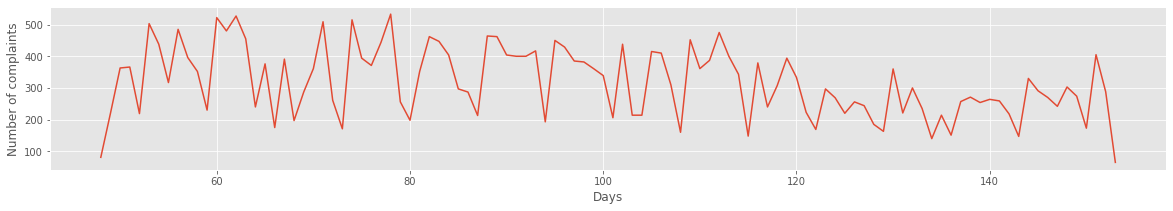

In [29]:
complaints_per_day=filtered_df.groupby(by=["DAYS"]).count()
plt.figure(figsize=(20,3))
plt.ylabel("Number of complaints")
plt.xlabel("Days")
plt.plot( complaints_per_day['SLNO'] )
plt.show()


Based on above plot, number of complaints range from 500-200 every day.

#### 2. Number of Complaints from each sector

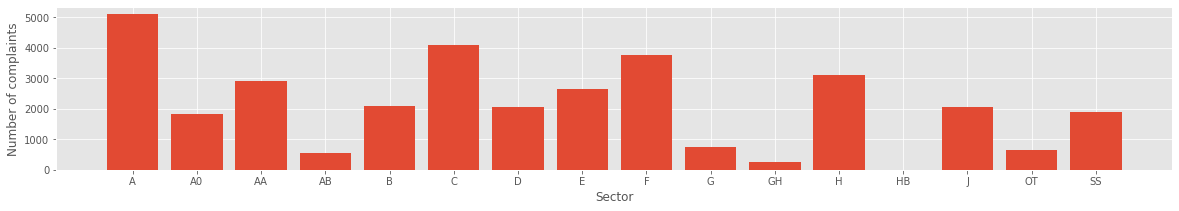

In [30]:
complaints_per_sector=filtered_df.groupby(by=["SECTOR"]).count()
plt.figure(figsize=(20,3))
plt.ylabel("Number of complaints")
plt.xlabel("Sector")
plt.bar(complaints_per_sector.index.values, complaints_per_sector['SLNO'] )
plt.show()

From the above graph, maximum number of complaints came from sector **A** followed by sector **C**.

#### 3. Number of complaints per category
Here, number complaints for each **CAT_DESCRIPTION** will be visualized.

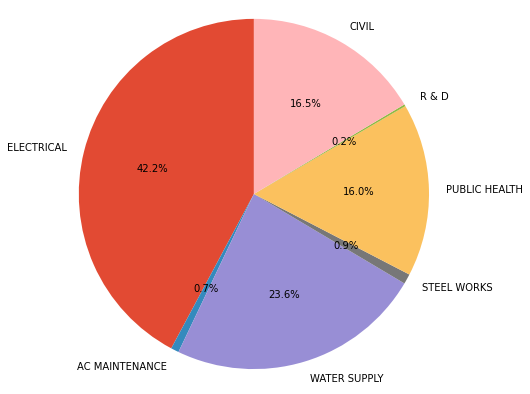

In [43]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
complaints_per_category = filtered_df.groupby(by=["CAT_DESCRIPTION"]).count()
labels = complaints_per_category.index.values
sizes = complaints_per_category["SLNO"]
category_dict={labels[i]:sizes[i] for i in range(len(labels))}

#ordering the labels for proper viewing
ordered_labels=["ELECTRICAL","AC MAINTENANCE","WATER SUPPLY","STEEL WORKS","PUBLIC HEALTH","R & D","CIVIL"]
ordered_sizes=[category_dict[val] for val in ordered_labels]

fig1, ax1 = plt.subplots()
fig1.set_size_inches(7,7)
ax1.pie(ordered_sizes, labels=ordered_labels, autopct='%1.1f%%',shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Based on the above pie chart, most number of cases are of **ELECTRICAL**, followed by **WATER SUPPLY**.

#### **Analyzing Complaint type** 
*Now let's analyse complaints for each category*

##### A. **ELECTRICAL**

In [46]:
electrical_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='ELECTRICAL']
electrical_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
0,1,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Hall,NEW,NaN,NaN,NaN,9,12,2,6,153
1,2,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Dining,NEW,NaN,NaN,NaN,9,12,2,6,153
2,3,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Bed Room - 2,NEW,NaN,NaN,NaN,9,12,2,6,153
3,4,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Bed Room - 1,NEW,NaN,NaN,NaN,9,12,2,6,153
4,5,6/2/21 9:12,201R,SS,ELECTRICAL,Calling Bell / Bell push switch,NaN,NaN,NaN,NEW,NaN,NaN,NaN,9,12,2,6,153


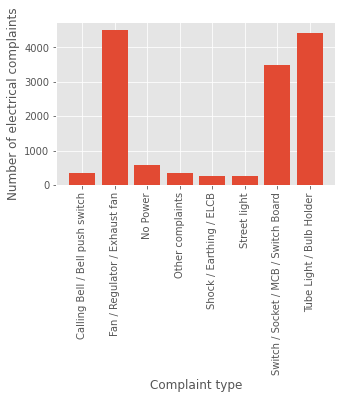

In [49]:
complaints_type=electrical_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of electrical complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Based on above graph most number of complaints in electrical category are **Fan/Regulator/Exhaust fan**, **Tube Light/Bulb Holder**, **Switch/Socket/MCB/Switch Board**.

##### B. **WATER SUPPLY**

In [51]:
water_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='WATER SUPPLY']
water_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
5,6,6/2/21 9:12,201R,SS,WATER SUPPLY,Sink,Sink Damaged,NaN,NaN,NEW,NaN,NaN,NaN,9,12,2,6,153
10,11,6/2/21 9:10,303U,C,WATER SUPPLY,Tap,Wash Basin,NaN,NaN,NEW,NaN,NaN,NaN,9,10,2,6,153
18,19,6/2/21 8:55,312T,F,WATER SUPPLY,Float Valve,Not Working,NaN,NaN,NEW,NaN,NaN,NaN,8,55,2,6,153
30,31,6/2/21 8:20,103U,J,WATER SUPPLY,No Water,Less Water to OH Tank,NaN,NaN,NEW,NaN,9.30-11.00,NaN,8,20,2,6,153
38,39,6/2/21 7:59,301S,J,WATER SUPPLY,Tap,Fresh Water Tap,NaN,NaN,NEW,NaN,9.30-11.00,NaN,7,59,2,6,153


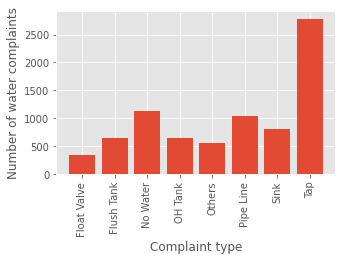

In [52]:
complaints_type=water_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of water complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Based on above plot, most of the complaints in **WATER SUPPLY** is related to Tap.

##### C. **CIVIL**

In [53]:
civil_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='CIVIL']
civil_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
6,7,6/2/21 9:11,201R,SS,CIVIL,Door,Frame,NaN,Balcony / Utility,NEW,NaN,NaN,NaN,9,11,2,6,153
7,8,6/2/21 9:11,201R,SS,CIVIL,Door,Shutter,NaN,Balcony / Utility,NEW,NaN,NaN,NaN,9,11,2,6,153
8,9,6/2/21 9:11,201R,SS,CIVIL,Others,White Wash / Distemper / Enamel,New qtr allotment,NaN,NEW,NaN,NaN,NaN,9,11,2,6,153
24,25,6/2/21 8:34,111Q,B,CIVIL,Others,OH Tank (RCC) Repairs / Leak,NaN,NaN,NEW,NaN,9.30-11.00,NaN,8,34,2,6,153
56,57,6/2/21 6:07,101Q,J,CIVIL,Others,OH Tank (RCC) Repairs / Leak,NaN,NaN,NEW,water tank top slabs damage,9.30-11.00,NaN,6,7,2,6,153


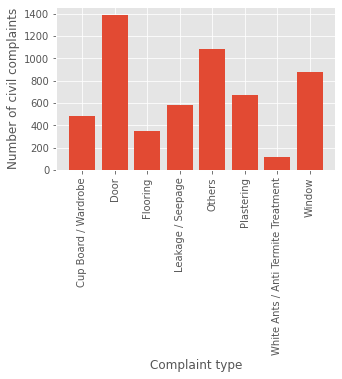

In [66]:
complaints_type=civil_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of civil complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Based on above plot, most of the complaints in **CIVIL** is related to Door.

D. **PUBLIC HEALTH**

In [55]:
public_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='PUBLIC HEALTH']
public_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
14,15,6/2/21 9:06,317P,C,PUBLIC HEALTH,Chokage,Manhole / Gully Trap,NaN,NaN,NEW,NaN,NaN,NaN,9,6,2,6,153
15,16,6/2/21 9:06,317P,C,PUBLIC HEALTH,Chokage,Inside Building,NaN,NaN,NEW,NaN,NaN,NaN,9,6,2,6,153
17,18,6/2/21 9:00,427P,H,PUBLIC HEALTH,Chokage,Inside Building,NaN,NaN,NEW,NaN,9.30-11.00,NaN,9,0,2,6,153
19,20,6/2/21 8:53,329Q,C,PUBLIC HEALTH,Grating Plate ( Jally ),NaN,NaN,NaN,NEW,NaN,9.30-11.00,NaN,8,53,2,6,153
20,21,6/2/21 8:52,329Q,C,PUBLIC HEALTH,Chokage,Toilet,NaN,NaN,NEW,NaN,9.30-11.00,NaN,8,52,2,6,153


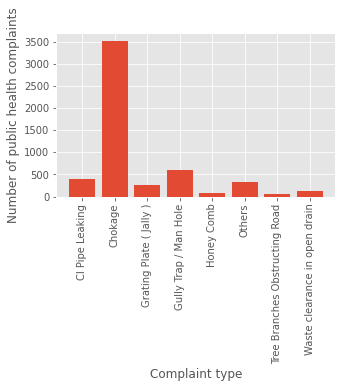

In [67]:
complaints_type=public_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of public health complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Majority of the civil complaints is related to Chokage

E. **R&D**

In [57]:
rnd_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='R & D']
rnd_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
546,547,5/31/21 11:32,512U,AA,R & D,Path Way Damaged / Water Stagnation,NaN,NaN,NaN,NEW,NaN,NaN,NaN,11,32,31,5,151
662,663,5/31/21 10:20,NaN,OT,R & D,Road Damaged / Cutting / Pot Holes,NaN,NaN,NaN,NEW,sec 10 jn.towords guard room at desapatrunipal...,NaN,NaN,10,20,31,5,151
1527,1528,5/28/21 0:41,347Q,C,R & D,Roadside Drain Damaged,NaN,NaN,NaN,NEW,NaN,NaN,NaN,0,41,28,5,148
2500,2501,5/24/21 13:18,209Q,H,R & D,Roadside Drain Damaged,NaN,NaN,NaN,NEW,NaN,9.30-11.00,NaN,13,18,24,5,144
2746,2747,5/23/21 18:15,57Q,A,R & D,Roadside Drain Damaged,NaN,NaN,NaN,NEW,NaN,14.30-16.00,NaN,18,15,23,5,143


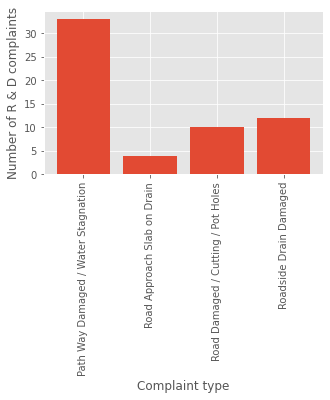

In [68]:
complaints_type=rnd_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of R & D complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Majority of the complaints in R & D is related to Path Way Damaged/ Water Stagnation

F. **STEEL WORKS**

In [59]:
steel_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='STEEL WORKS']
steel_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
386,387,5/31/21 19:02,102Q,J,STEEL WORKS,Tank Cover / Door at Terrace,NaN,NaN,NaN,NEW,Tank cover damaged. No door te,11.00-12.30,NaN,19,2,31,5,151
438,439,5/31/21 16:18,101S,A,STEEL WORKS,Gate Repairs,NaN,NaN,NaN,NEW,main door lock arrangement to be repaired,9.30-11.00,NaN,16,18,31,5,151
656,657,5/31/21 10:26,427T,F,STEEL WORKS,Tank Cover / Door at Terrace,NaN,NaN,NaN,NEW,NaN,9.30-11.00,NaN,10,26,31,5,151
910,911,5/30/21 10:55,335R,H,STEEL WORKS,Tank Cover / Door at Terrace,NaN,NaN,NaN,NEW,Oh tank cover damaged,14.30-16.00,NaN,10,55,30,5,150
1082,1083,5/29/21 13:31,101S,A,STEEL WORKS,Stair Case / Balcony Hand Rail,NaN,NaN,NaN,NEW,iron stair case to the roof is not proper and ...,9.30-11.00,NaN,13,31,29,5,149


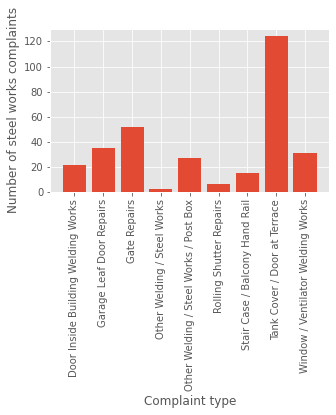

In [69]:
complaints_type=steel_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of steel works complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Most of the steel works complaints is related to Tank Cover/ Door at Terrace.

G. **AC MAINTENANCE**

In [64]:
ac_df=filtered_df[filtered_df["CAT_DESCRIPTION"]=='AC MAINTENANCE']
ac_df.head(5)

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,HOUR,MINUATE,DATE,MONTH,DAYS
168,169,6/1/21 15:25,NaN,OT,AC MAINTENANCE,AC Complaint,NaN,NaN,Room No.,NEW,AC not working. No cooling,NaN,313,15,25,1,6,152
170,171,6/1/21 15:15,NaN,OT,AC MAINTENANCE,AC Complaint,NaN,NaN,15,NEW,Not working,NaN,NaN,15,15,1,6,152
171,172,6/1/21 15:09,NaN,GH,AC MAINTENANCE,AC Complaint,NaN,NaN,39,NEW,AC not working,NaN,NaN,15,9,1,6,152
189,190,6/1/21 12:55,109R,C,AC MAINTENANCE,AC Complaint,NaN,NaN,NaN,NEW,NaN,NaN,NaN,12,55,1,6,152
364,365,5/31/21 21:50,NaN,J,AC MAINTENANCE,AC Complaint,NaN,NaN,NaN,NEW,PrinSSpals room AC not working,NaN,NaN,21,50,31,5,151


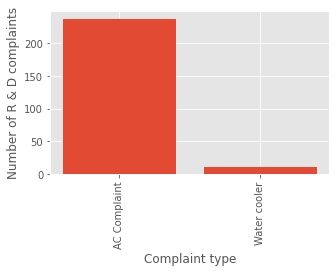

In [65]:
complaints_type=ac_df.groupby(by=["COMPLAINT_TYPE"]).count()

plt.figure(figsize=(5,3))
plt.ylabel("Number of AC Maintainence complaints")
plt.xlabel("Complaint type")
plt.xticks(rotation=90)
plt.bar(complaints_type.index.values, complaints_type['SLNO'] )
plt.show()

Most of the AC Maintainence complaints is AC Complaint

#### 4. Visualizing **STATUS** 
To visualize status we can plot 
- violin plot
- histogram 
We can do this for each category

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

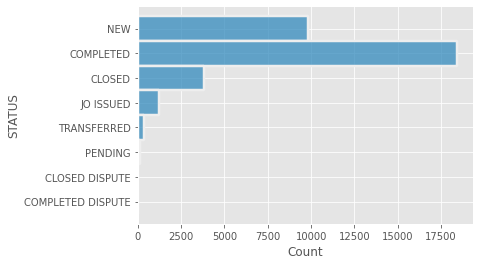

In [85]:
sns.histplot(data=filtered_df, y="STATUS")

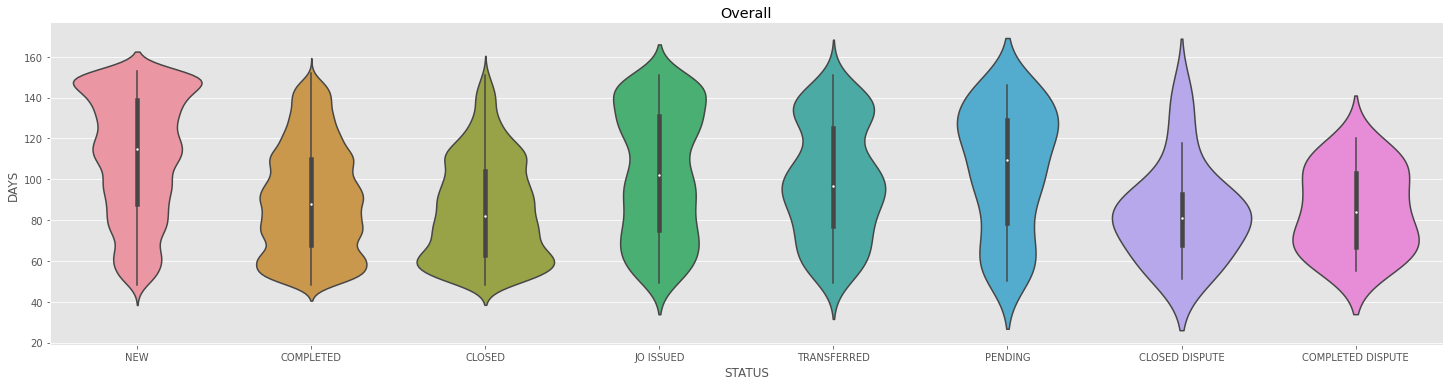

In [79]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=filtered_df,aspect=4).set(title='Overall')

Overall most of the cases are either completed or new

##### A. ELECTRICAL

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

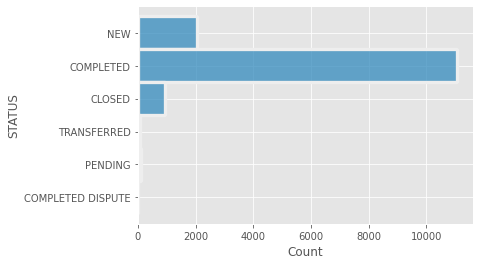

In [86]:
sns.histplot(data=electrical_df, y="STATUS")

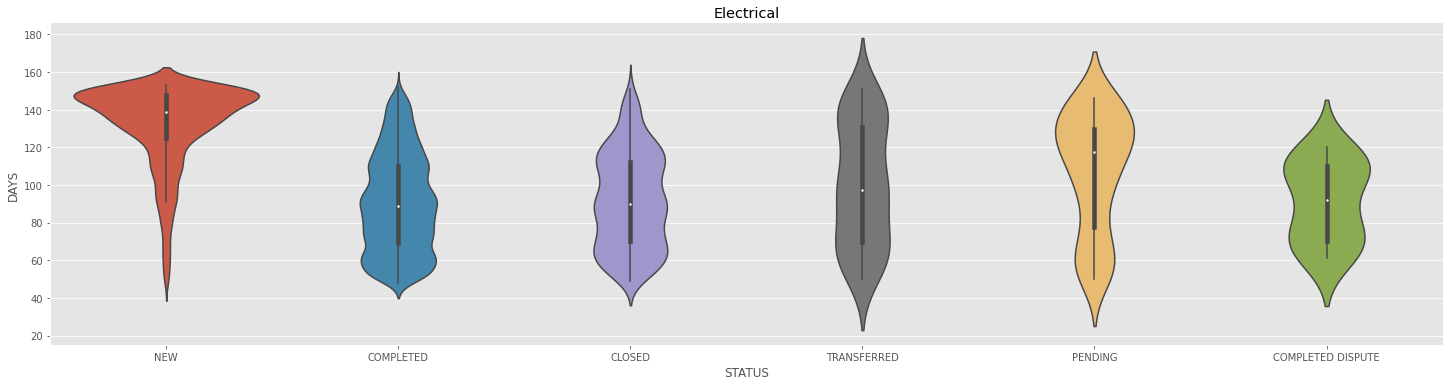

In [81]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=electrical_df,aspect=4).set(title='Electrical')

Most of the electrical cases are completed implying that electrical cases are handled quickly

##### B. WATER SUPPLY

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

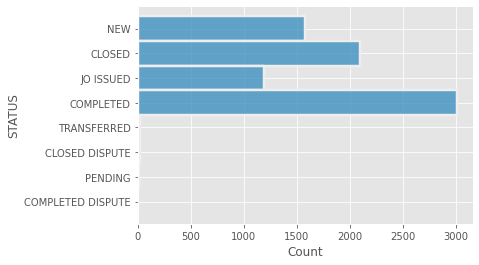

In [87]:
sns.histplot(data=water_df, y="STATUS")

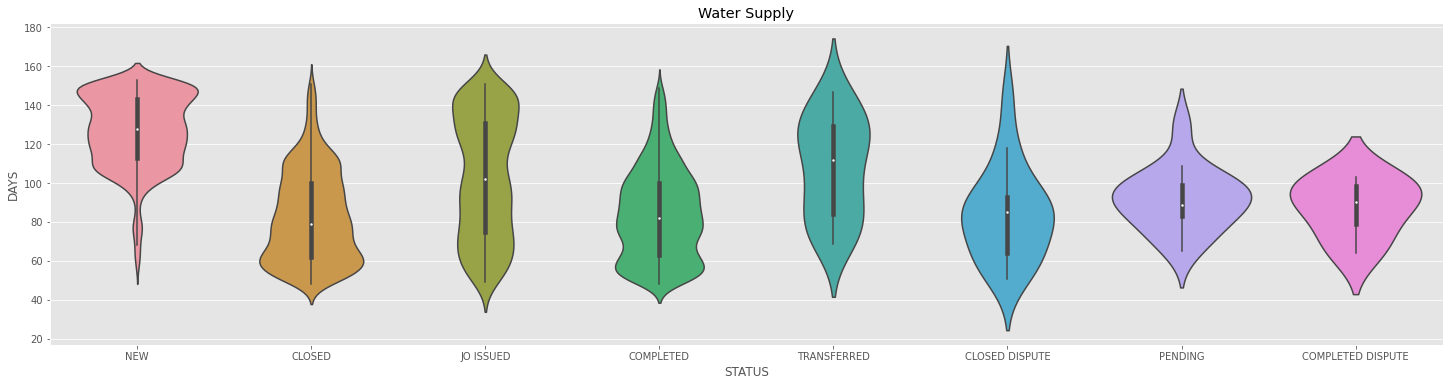

In [99]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=water_df,aspect=4).set(title='Water Supply')

Most of the water supply cases are also completed.

##### C. CIVIL

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

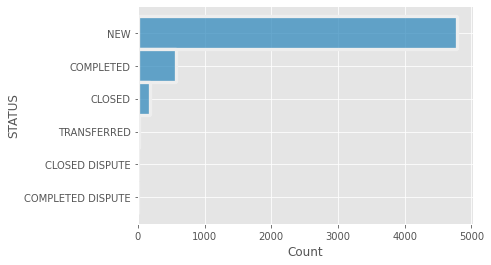

In [89]:
sns.histplot(data=civil_df, y="STATUS")

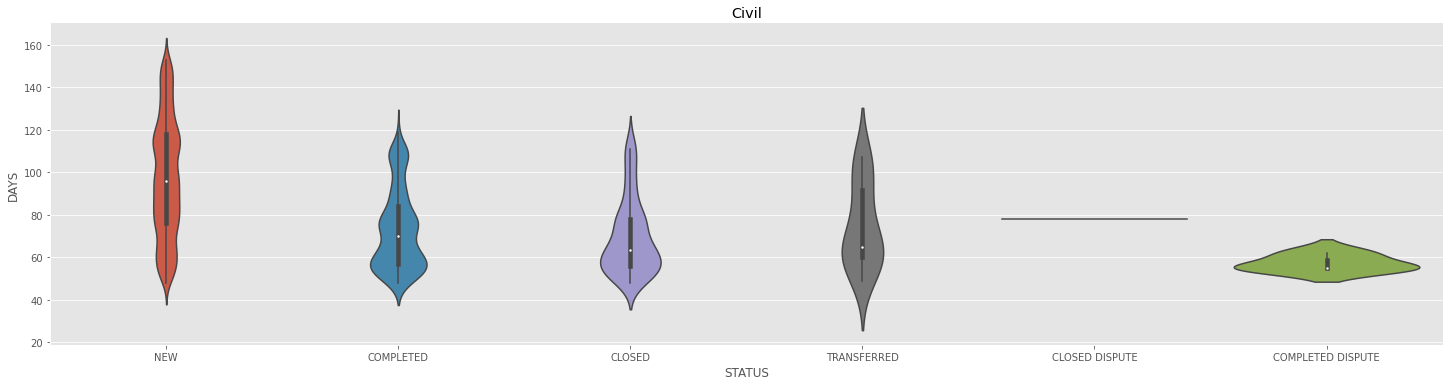

In [100]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=civil_df,aspect=4).set(title='Civil')

Most of the civil cases are new implying that, civil cases are not handled that quickly. Similar analysis can be made for other graphs too by looking at bar plots and violin plots.

##### D. PUBLIC HEALTH

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

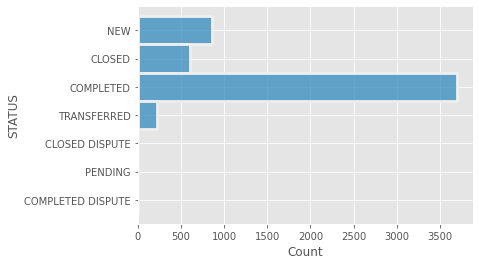

In [91]:
sns.histplot(data=public_df, y="STATUS")

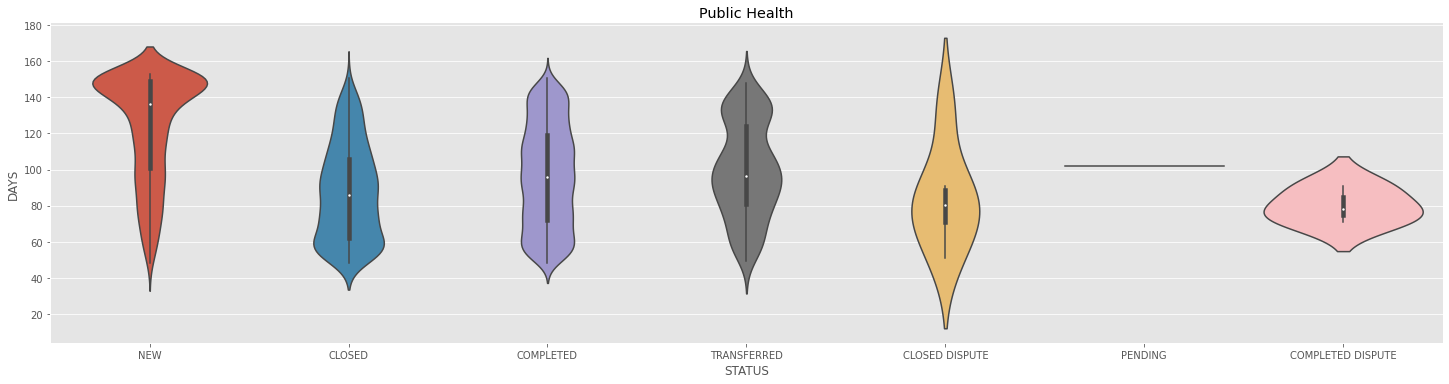

In [101]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=public_df,aspect=4).set(title='Public Health')

##### E. R & D

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

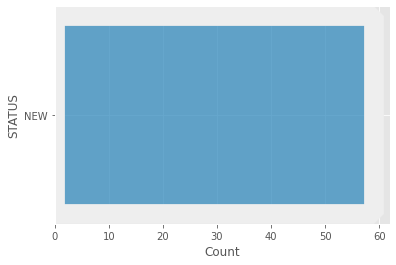

In [93]:
sns.histplot(data=rnd_df, y="STATUS")

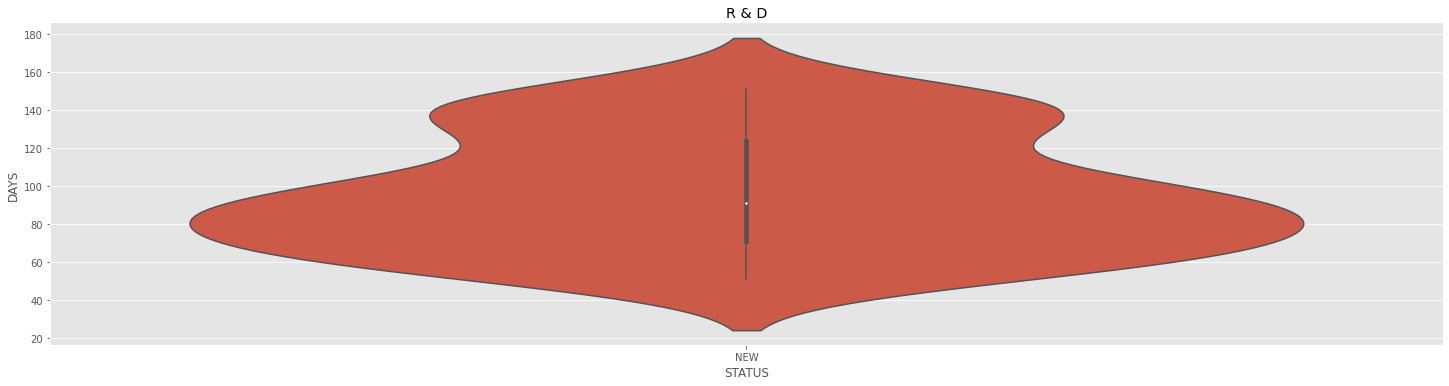

In [102]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=rnd_df,aspect=4).set(title='R & D')

##### F. STEEL WORKS

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

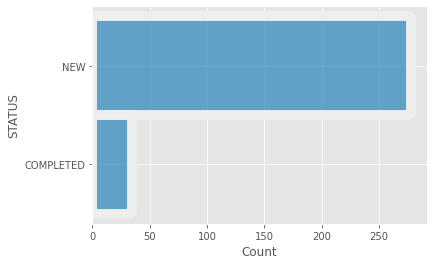

In [95]:
sns.histplot(data=steel_df, y="STATUS")

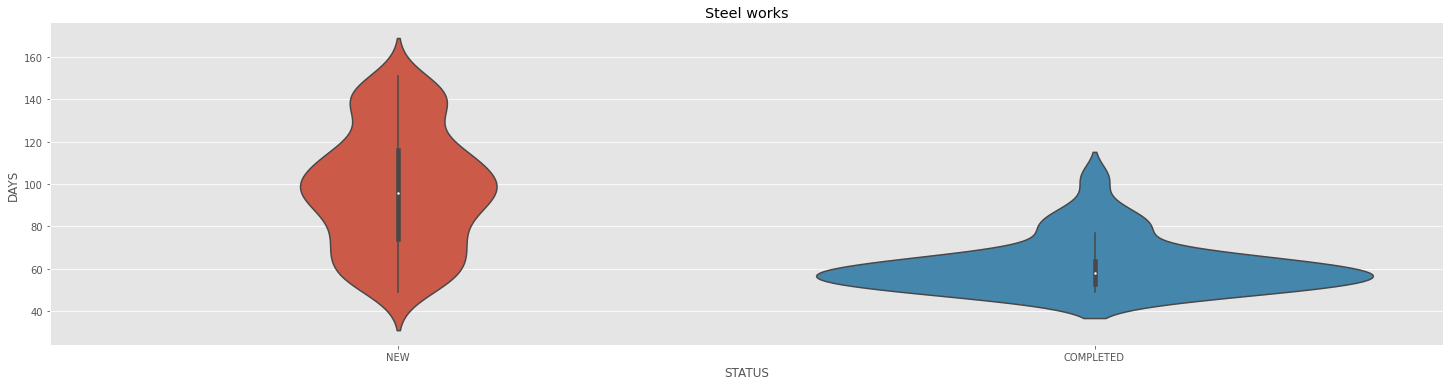

In [103]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=steel_df,aspect=4).set(title='Steel works')

##### G. AC Maintenance

<AxesSubplot:xlabel='Count', ylabel='STATUS'>

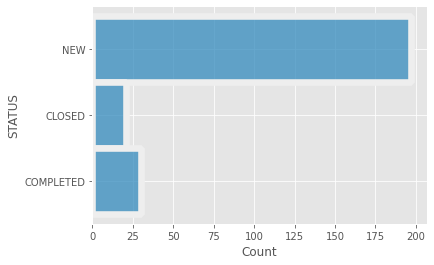

In [97]:
sns.histplot(data=ac_df, y="STATUS")

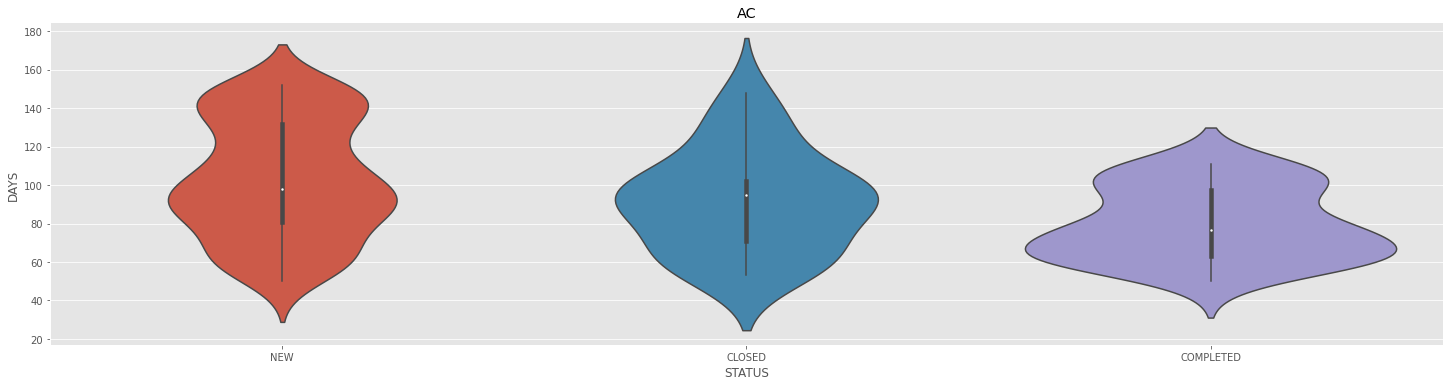

In [104]:
sns.catplot(x="STATUS", y="DAYS", kind="violin", data=ac_df,aspect=4).set(title='AC')

##### 5. Vizualizing RES_PREF_TIME

<AxesSubplot:xlabel='RES_PREF_TIME', ylabel='Count'>

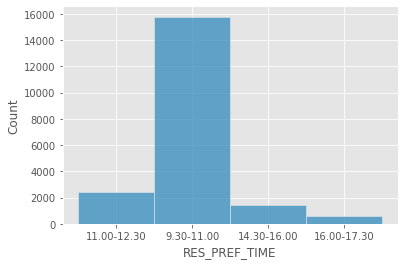

In [109]:
sns.histplot(data=filtered_df['RES_PREF_TIME'].dropna())

Based on the above plot preferred time to address the complaint is 9:30-11:00